<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/ConvAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.models as tfkm
import tensorflow.keras.layers as tfkl
import tensorflow.keras.utils as tfku

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar10.load_data()

In [4]:
@tfku.register_keras_serializable()
class GaussianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        gaussian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        gaussian_filter = np.array([
            [1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [gaussian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        gaussian.set_weights([gaussian_filter])

        gaussian.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [5]:
@tfku.register_keras_serializable()
class LaplacianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        laplacian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        laplacian_filter = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])[..., np.newaxis, np.newaxis]

        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [laplacian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        laplacian.set_weights([laplacian_filter])

        laplacian.trainable = False


        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [6]:
@tfku.register_keras_serializable()
class DownPoolLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])

        out = y

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [7]:
@tfku.register_keras_serializable()
class EdgeDetectionLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        x = GaussianConv()(x)
        x = LaplacianConv()(x)
        x = tfkl.ReLU()(x)

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [8]:
@tfku.register_keras_serializable()
class PyramidConvFeatures(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = tfkl.Rescaling(scale = 1/127.5, offset = -1)(x)

        x0 = EdgeDetectionLayer()(x)


        x = DownPoolLayer()(x)
        x1 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x2 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x3 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x4 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x5 = EdgeDetectionLayer()(x)

        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x5)

        x = tfkl.Concatenate(axis = -1)([x4, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)


        x = tfkl.Concatenate(axis = -1)([x3, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x2, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x1, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x0, x])
        x = tfkl.Activation('tanh')(x)
        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [9]:
def create_base_model():
    img = tfkl.Input([32, 32, 3], name = 'image')
    labels = tfkl.Input([1], name = 'labels')

    x = PyramidConvFeatures()(img)
    x = tfkl.Reshape([32 * 32, -1])(x)
    x = tfkl.BatchNormalization(axis = -1)(x)

    features = x

    class_embed = tfkl.Embedding(input_dim = 10, output_dim = 189)(labels)


    x = features
    y = class_embed

    res = x
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    x = tfkl.Attention(use_scale = True)([x, y])
    x = tfkl.Add()([x, res])

    res = y
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    y = tfkl.Attention(use_scale = True)([y, x])
    y = tfkl.Add()([y, res])

    res = x
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    x = tfkl.Attention(use_scale = True)([x, y])
    x = tfkl.Add()([x, res])

    res = y
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    y = tfkl.Attention(use_scale = True)([y, x])
    y = tfkl.Add()([y, res])

    res = x
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    x = tfkl.Attention(use_scale = True)([x, y])
    x = tfkl.Add()([x, res])

    res = y
    x = tfkl.BatchNormalization(axis = -1)(x)
    y = tfkl.BatchNormalization(axis = -1)(y)
    y = tfkl.Attention(use_scale = True)([y, x])
    y = tfkl.Add()([y, res])

    x = tfkl.Dense(3)(x)
    x = tfkl.Reshape([32, 32, -1])(x)
    x = tfkl.Activation('tanh')(x)

    y = tfkl.Dense(10)(y)
    y = tfkl.Flatten()(y)

    return tfkm.Model(inputs = [img, labels], outputs = [x, y])


In [10]:
base_model = create_base_model()

In [11]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 pyramid_conv_features (Pyr  (None, 32, 32, 189)          108       ['image[0][0]']               
 amidConvFeatures)                                                                                
                                                                                                  
 reshape (Reshape)           (None, 1024, 189)            0         ['pyramid_conv_features[0][0]'
                                                                    ]                             
                                                                                              

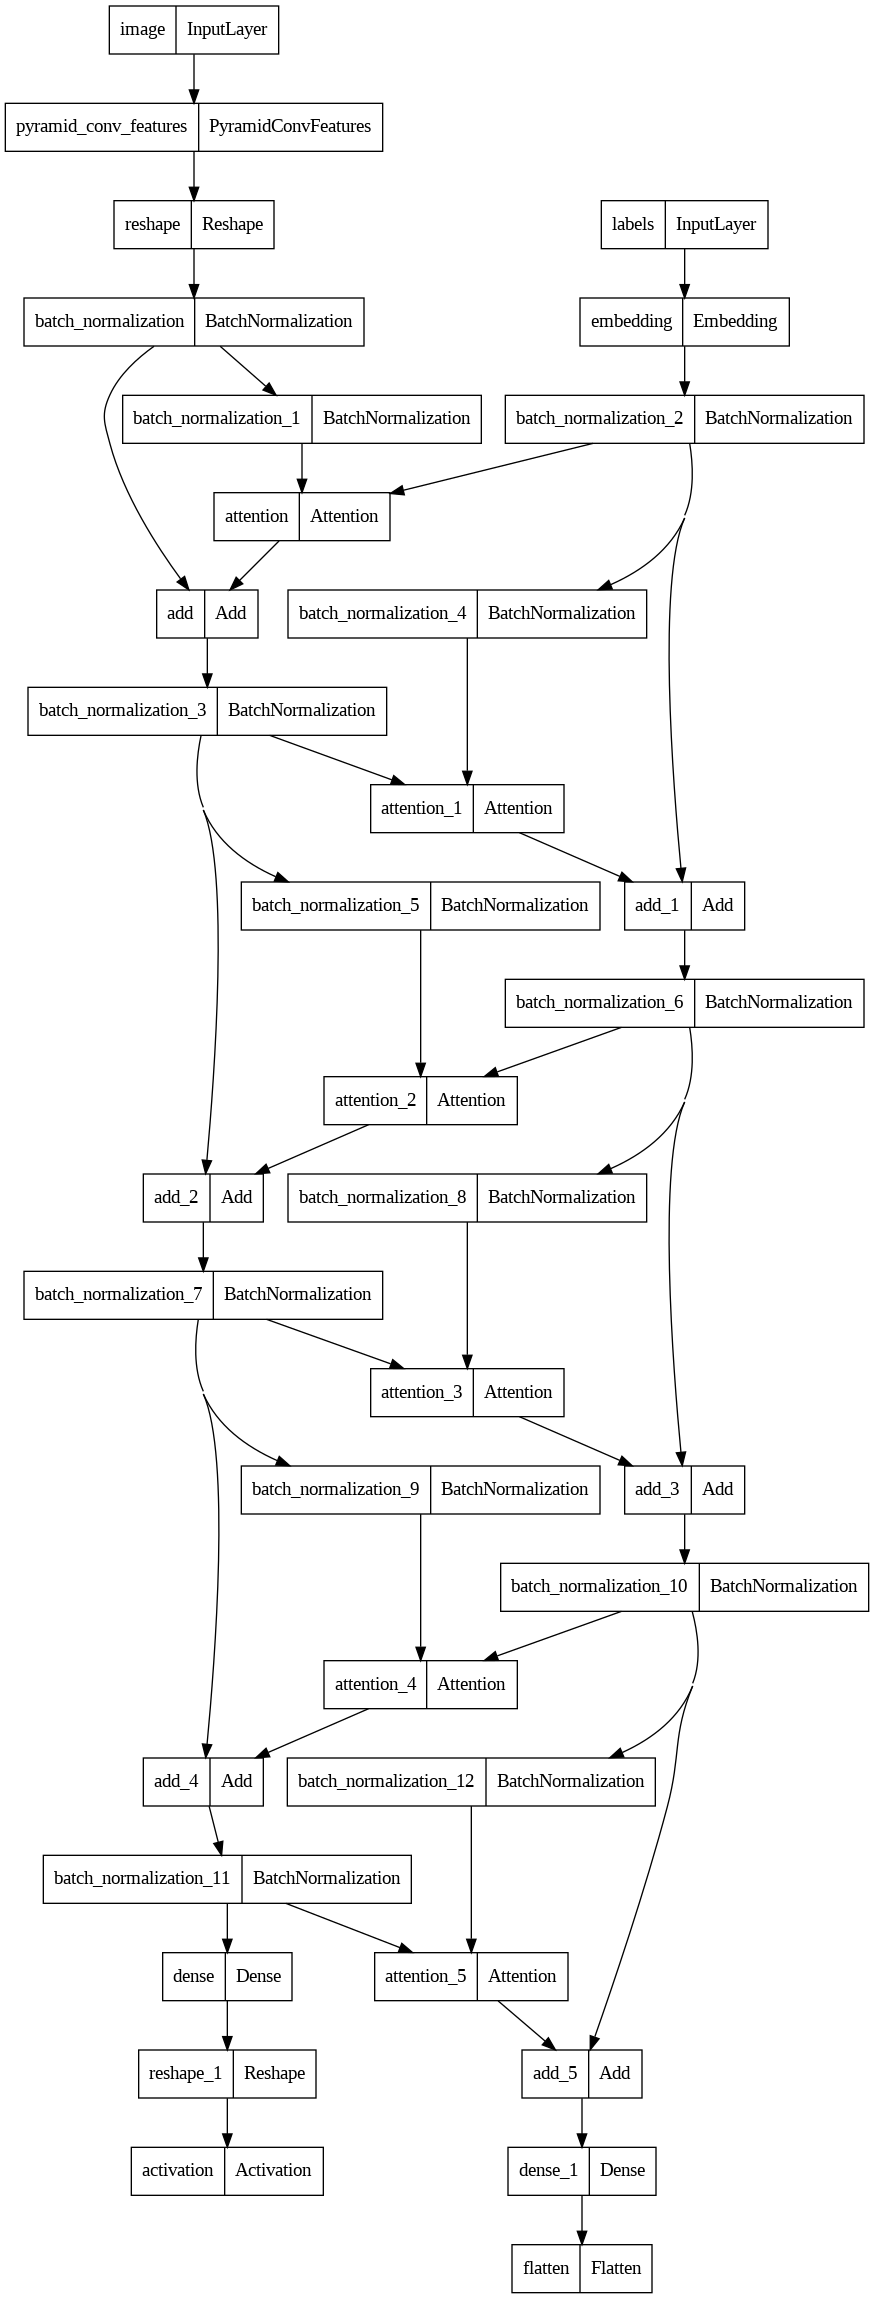

In [12]:
tfku.plot_model(base_model)

In [14]:
base_model.compile(
    optimizer = 'adam',
    loss = ['mean_squared_error', tfk.losses.SparseCategoricalCrossentropy(from_logits = True)],
    metrics = [['mean_squared_error'], ['accuracy']]
)

In [15]:
norm_x_train = x_train/127.5 - 1
norm_x_test = x_test/127.5 - 1

In [16]:
dataset = (
    tf.data.Dataset.from_tensor_slices(((x_train, y_train), (norm_x_train, y_train)))
                   .repeat(1)
                   .batch(8)
)

base_model.fit(dataset)

6250/6250 [==============================] - 701s 109ms/step - loss: 0.0959 - activation_loss: 0.0900 - flatten_loss: 0.0059 - activation_mean_squared_error: 0.0900 - flatten_accuracy: 0.9987


In [17]:
base_model.evaluate(x = [x_test, y_test], y = [norm_x_test, y_test])

313/313 [==============================] - 44s 134ms/step - loss: 0.0553 - activation_loss: 0.0553 - flatten_loss: 9.4032e-07 - activation_mean_squared_error: 0.0553 - flatten_accuracy: 1.0000


[0.055287621915340424,
 0.055286675691604614,
 9.403170793120808e-07,
 0.055286675691604614,
 1.0]

In [20]:
pred_x, _ = base_model.predict([x_test[:10], y_test[:10]])

1/1 [==============================] - 0s 70ms/step


In [21]:
pred_img = np.uint8((pred_x + 1) * 255/2)

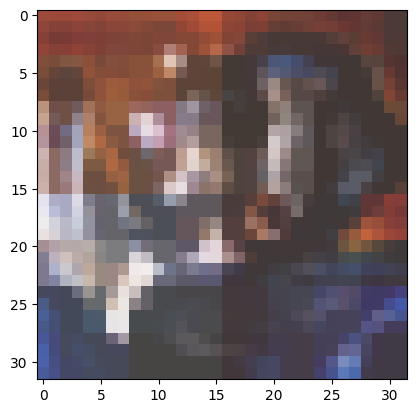

In [24]:
plt.imshow(pred_img[0])

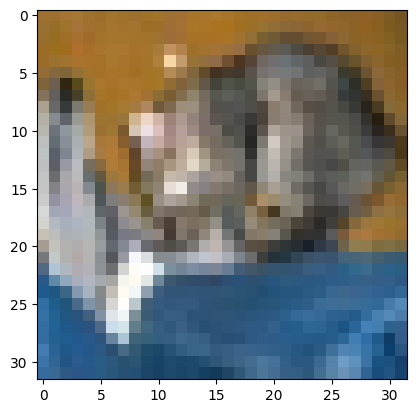

In [25]:
plt.imshow(np.uint8(x_test[0]))